In [ ]:
import torch
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 7.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=6cc8b786fba5ca4ed392130bde2ffb6e3a2f297c5389e0247413220f00139dbc
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 9.4 MB/s 
     |████████████████████████████████| 130 kB 7.1 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 147 kB 58.1 MB/s 
     |████████████████████████████████| 74 kB 3.7 MB/s 
     |████████████████████████████████| 749 kB 63.9 MB/s 
     |████████████████████████████████

In [ ]:
%cd /content/drive/Shareddrives/trainmodel/detectron
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

/content/drive/Shareddrives/trainmodel/detectron


In [ ]:
%cd /content/drive/Shareddrives/trainmodel/detectron
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/Shareddrives/trainmodel/data/anotation/train.json", "/content/drive/Shareddrives/trainmodel/data/images/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/Shareddrives/trainmodel/data/anotation/val.json", "/content/drive/Shareddrives/trainmodel/data/images/val")
#register_coco_instances("my_dataset_test", {}, "/content/drive/Shareddrives/trainmodel/datascale/images/test/test.json", "/content/drive/Shareddrives/trainmodel/datascale/images/test")

/content/drive/Shareddrives/trainmodel/detectron


In [ ]:
%cd /content/drive/Shareddrives/trainmodel/detectron
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

/content/drive/Shareddrives/trainmodel/detectron


/content/drive/Shareddrives/trainmodel/detectron
[04/21 13:21:16 d2.data.datasets.coco]: Loading /content/drive/Shareddrives/trainmodel/data/anotation/train.json takes 1.54 seconds.
[04/21 13:21:16 d2.data.datasets.coco]: Loaded 3516 images in COCO format from /content/drive/Shareddrives/trainmodel/data/anotation/train.json


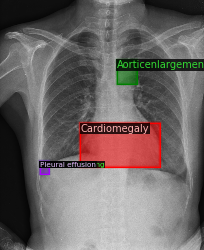

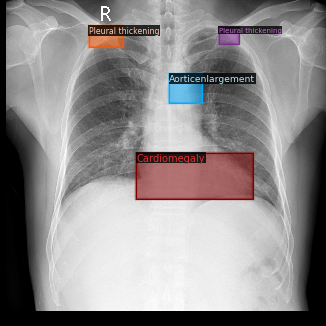

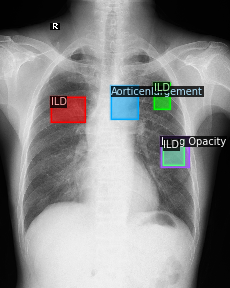

In [ ]:
%cd /content/drive/Shareddrives/trainmodel/detectron
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
%cd /content/drive/Shareddrives/trainmodel/detectron
#from .detectron2.tools.train_net import Trainer
from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.MAX_ITER = 9000 # adjust up if val mAP is still rising, adjust down if overfit

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14
cfg.TEST.EVAL_PERIOD = 1000
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

/content/drive/Shareddrives/trainmodel/detectron
[04/21 13:25:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_fea

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/21 13:25:28 d2.evaluation.evaluator]: Inference done 11/878. Dataloading: 0.2186 s/iter. Inference: 0.0829 s/iter. Eval: 0.0012 s/iter. Total: 0.3027 s/iter. ETA=0:04:22
[04/21 13:25:34 d2.evaluation.evaluator]: Inference done 27/878. Dataloading: 0.2466 s/iter. Inference: 0.0833 s/iter. Eval: 0.0005 s/iter. Total: 0.3305 s/iter. ETA=0:04:41


KeyboardInterrupt: ignored

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git

fatal: destination path 'detectron2' already exists and is not an empty directory.


In [ ]:
%cd /content/detectron2/detectron2/evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from coco_evaluation import COCOEvaluator, inference_on_dataset
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

/content/detectron2/detectron2/evaluation


ImportError: ignored

In [ ]:
%cd /content/drive/Shareddrives/trainmodel/detectron

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

/content/drive/Shareddrives/trainmodel/detectron


In [ ]:
from PIL import Image
import pandas as pd
from detectron2.utils.visualizer import ColorMode
import glob
import os
from math import ceil
from typing import Any, Dict, List

def format_pred(labels, boxes, scores):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)
idx=0
resutls_pre = []
for imageName in glob.glob('/content/drive/Shareddrives/trainmodel/data/images/test1/*jpg'):
  name_img =imageName.replace("/content/drive/Shareddrives/trainmodel/data/images/test1/","").replace(".jpg","").strip()
  #print(name_img)
  idx+=1
  if idx%50==0:
    print("dự đoán được số ảnh",idx)
  im = cv2.imread(imageName)
  outputs = predictor(im)
  instances = outputs["instances"]
  if len(instances) == 0:
            # No finding, let's set 14 0 0 0 0.
            result = {"image_id": name_img, "PredictionString": "14 1.0 0 0 1 1"}
  else:
     fields = instances.get_fields()
     pred_classes = fields["pred_classes"]  
     pred_scores = fields["scores"]
     pred_boxes = fields["pred_boxes"].tensor
     pred_classes_array = pred_classes.cpu().numpy()
     pred_boxes_array = pred_boxes.cpu().numpy()
     pred_scores_array = pred_scores.cpu().numpy()
     result = {"image_id":name_img ,"PredictionString":format_pred(pred_classes_array, pred_boxes_array, pred_scores_array)}
  resutls_pre.append(result)


submission_det = pd.DataFrame(resutls_pre, columns=['image_id', 'PredictionString'])
submission_det.to_csv("/content/drive/Shareddrives/trainmodel/detectron/submit_csv/submit_detectron2.csv", index=False)
submission_det
  

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


dự đoán được số ảnh 50
dự đoán được số ảnh 100
dự đoán được số ảnh 150
dự đoán được số ảnh 200
dự đoán được số ảnh 250
dự đoán được số ảnh 300
dự đoán được số ảnh 350
dự đoán được số ảnh 400
dự đoán được số ảnh 450
dự đoán được số ảnh 500
dự đoán được số ảnh 550
dự đoán được số ảnh 600
dự đoán được số ảnh 650
dự đoán được số ảnh 700
dự đoán được số ảnh 750
dự đoán được số ảnh 800
dự đoán được số ảnh 850
dự đoán được số ảnh 900
dự đoán được số ảnh 950
dự đoán được số ảnh 1000
dự đoán được số ảnh 1050
dự đoán được số ảnh 1100
dự đoán được số ảnh 1150
dự đoán được số ảnh 1200
dự đoán được số ảnh 1250
dự đoán được số ảnh 1300
dự đoán được số ảnh 1350
dự đoán được số ảnh 1400
dự đoán được số ảnh 1450
dự đoán được số ảnh 1500
dự đoán được số ảnh 1550
dự đoán được số ảnh 1600
dự đoán được số ảnh 1650
dự đoán được số ảnh 1700
dự đoán được số ảnh 1750
dự đoán được số ảnh 1800
dự đoán được số ảnh 1850
dự đoán được số ảnh 1900
dự đoán được số ảnh 1950
dự đoán được số ảnh 2000
dự đoán được số ảnh 

,image_id,PredictionString
0,acb798cac2ce66c6c9b1570fab4e4adc,6 0.2366929054260254 415 1475 1021 2254 3 0.22...
1,ae1a1f3641ea3d97e97fd07bbc7edb5d,3 0.6588621735572815 904 1722 1833 2207 11 0.5...
2,ae7fa77d4ac17896070888e1e62f4973,0 0.9858973026275635 1169 776 1436 1109 3 0.95...
3,af42eedb38176dadaa09bfccbe65e16a,0 0.9951615929603577 1149 834 1393 1096 3 0.98...
4,ae9c7e52d8a31c3898dcd1bcf7a6f19f,0 0.9857653975486755 1083 434 1282 625 9 0.723...
...,...,...
2995,5acff5ccf1bcb3137e2c12dc99919396,3 0.9946228265762329 854 1467 2082 1902 0 0.99...
2996,5b50b56feb8f2129463d1c825ceb00f0,0 0.988535463809967 1236 777 1486 1081 3 0.964...
2997,5a85e877ecee5e7fd6cf3b9a4bc802d2,0 0.8989064693450928 956 736 1141 956 11 0.827...
2998,5b1e75dd15524be14eb8722cb4370490,0 0.7392717599868774 1384 857 1646 1156 3 0.64...
